In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_physics
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
import space
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 200
TRAIN_SIZE  = 0.7
NOISE       = 0.#05
MESH_SIZE   = 100

POPSIZE          = 100
MAX_STREE_DEPTH  = 5
MAX_STREE_LENGTH = 20
GENERATIONS      = 50
GROUP_SIZE       = 5  # tournament selector.
MUTATION_RATE    = 0.15
ELITISM          = 1

LIBSIZE       = 2000
LIB_MAXDEPTH  = 3
LIB_MAXLENGTH = 10

RANDSTATE = None#124

In [3]:
randstate.setstate(RANDSTATE)

#S = dataset_misc1d.MagmanDatasetScaled()
S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()
#S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_physics.AircraftLift()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

solutionCreator = gp_creator.PTC2RandomSolutionCreator(nvars=S.nvars)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, MAX_STREE_LENGTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True),
      #gp.NumericParameterMutator(all=False)
      )

mesh           = space.MeshSpace(S_train, S.knowledge, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, mesh)
r2_evaluator   = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, r2_evaluator)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH, MAX_STREE_LENGTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)

settings = gp.GPSettings(
      POPSIZE, GENERATIONS, MAX_STREE_DEPTH, MAX_STREE_LENGTH, S_train, S_test,
      creator=solutionCreator,
      evaluator=evaluator,
      selector=selector,
      crossover=crossover,
      mutator=multiMutator,
      corrector=corrector,
      mutrate=MUTATION_RATE,
      elitism=ELITISM,
      knowledge=S.knowledge)
symb_regressor = gp.GP(settings)
#symb_regressor = gp.MOGP(settings)

import profiling

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
print(f"Length: {best_stree.get_nnodes()}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")

  0%|          | 0/49 [00:00<?, ?it/s]

         1744542 function calls (1533826 primitive calls) in 5.675 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4900    0.124    0.000    5.600    0.001 corrector.py:30(correct)
     4900    0.074    0.000    3.099    0.001 corrector.py:83(backprop_know)
     4858    0.099    0.000    1.607    0.000 library.py:515(cquery)
13752/4900    0.016    0.000    1.280    0.000 syntax_tree.py:135(pull_know)
9395/4344    0.212    0.000    1.277    0.000 binop.py:185(pull_know)
     4442    0.061    0.000    1.272    0.000 library.py:563(__local_cquery)
     6044    0.139    0.000    0.937    0.000 utils.py:288(is_symmetric)
     6044    0.017    0.000    0.798    0.000 <__array_function__ internals>:177(allclose)
     6044    0.015    0.000    0.779    0.000 numeric.py:2199(allclose)
     4893    0.011    0.000    0.723    0.000 library.py:78(query)
     4893    0.430    0.000    0.712    0.000 _kdtree.py:363(query)
     604

In [5]:
profiling.print_stats()

         1744542 function calls (1533826 primitive calls) in 5.675 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4900    0.124    0.000    5.600    0.001 corrector.py:30(correct)
     4900    0.074    0.000    3.099    0.001 corrector.py:83(backprop_know)
     4858    0.099    0.000    1.607    0.000 library.py:515(cquery)
13752/4900    0.016    0.000    1.280    0.000 syntax_tree.py:135(pull_know)
9395/4344    0.212    0.000    1.277    0.000 binop.py:185(pull_know)
     4442    0.061    0.000    1.272    0.000 library.py:563(__local_cquery)
     6044    0.139    0.000    0.937    0.000 utils.py:288(is_symmetric)
     6044    0.017    0.000    0.798    0.000 <__array_function__ internals>:177(allclose)
     6044    0.015    0.000    0.779    0.000 numeric.py:2199(allclose)
     4893    0.011    0.000    0.723    0.000 library.py:78(query)
     4893    0.430    0.000    0.712    0.000 _kdtree.py:363(query)
     604

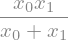

In [6]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

In [7]:
best_stree.clear_output()
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
S.evaluate_extra(best_stree)

{'mse': 0.0, 'rmse': 0.0, 'r2': 1.0}

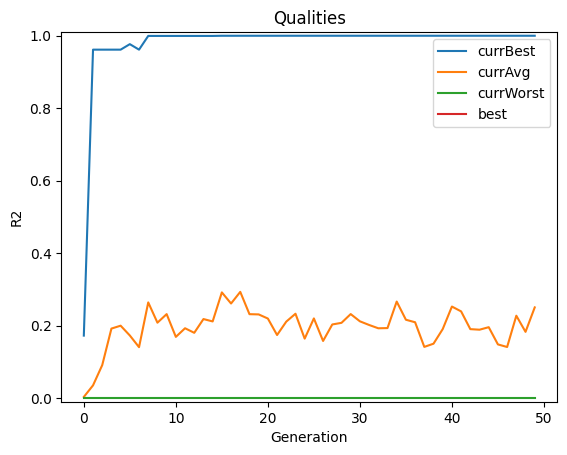

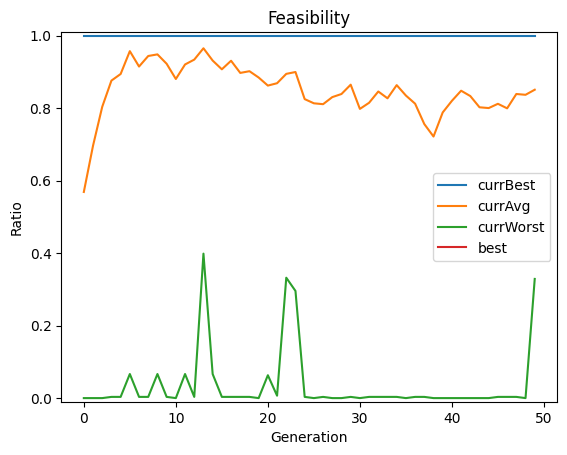

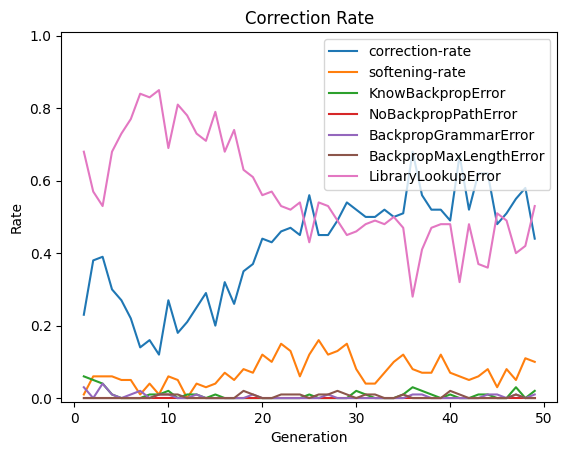

In [8]:
symb_regressor.stats.plot()

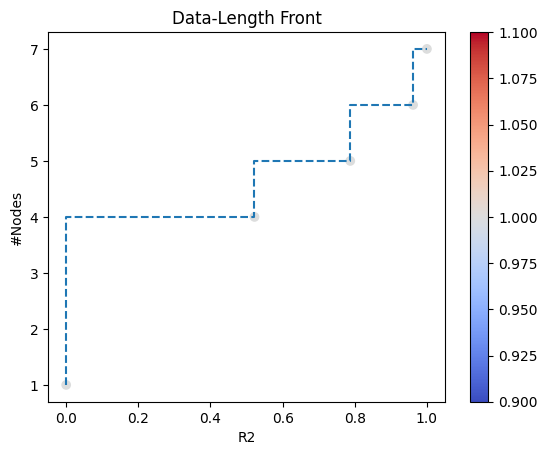

Extent of Convergence: 0.8037468156154242


,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,4.24,0,1.054712e-16,1.110223e-16,1,(),1,inf
1,1,((x1 * x0) / (x1 + x0)),0,6.500000e-01,1.000000e+00,7,"(/, +, *)",1,inf
2,2,sqrt((x1 + x0)),0,4.176139e-01,5.220173e-01,4,"(+, sqrt)",1,1.454214
3,3,(0.03 * (x0 * x1)),0,5.906605e-01,7.875473e-01,5,(*),1,0.772941
4,4,(0.50 * sqrt((x0 * x1))),0,6.731374e-01,9.616249e-01,6,"(*, sqrt)",1,0.545786


In [9]:
pd_data = []
front_tracker = symb_regressor.fea_front_tracker

for frontidx in range(len(front_tracker.front)):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data*(1.-min(1.,length/20)), data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

front_tracker.plot(0)
print(f"Extent of Convergence: {front_tracker.compute_extend_of_convergence((0.0,1.0), (1,MAX_STREE_LENGTH))}")
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)